<a href="https://colab.research.google.com/github/jadelekeGit/Coursera_Capstone1/blob/master/Restaurant_Business_in_Queens__A_Blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# French' Restaurants Business in Queens, NYC: A Blog

#### JULIEN ADELEKE

In [ ]:

import numpy as np
import pandas as pd
pd.set_option('display.max_column', None)
pd.set_option('display.max_row', None)

import json
import xml

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

!pip install geocoder
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

!pip install folium
import folium
from bs4 import BeautifulSoup

print('Librairies imported.')

     |████████████████████████████████| 98 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 7.3 MB/s  eta 0:00:01
Librairies imported.


In [ ]:

#Loading data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [ ]:
with open('newyork_data.json') as f:
    newyork_data = json.load(f)

In [ ]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [ ]:

def get_newyork_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    newyork_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return newyork_data



def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude



def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### New York City is the most populous city in the United states of America. It covers more than 302 square miles with a population of more than 8 millions people. With more than 20 millions people in its metropolitan statistical area NYC is certainly the largest metropolitan area in the world and is one of the world's most populous megacities. It's also one of the best tourist destination in the world and a great place for business. Described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. But NYC can be also thought as the Capital of gastronomy.

### In Fact, as many as 800 languages are spoken in NYC, making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world. Each linguististic group comes with its culinary specialies. Thus, beside amercan specialities we have exotic cusines like those of Mexicans, Italians, Chineses, Indians and Frenchs to only name these. Flavors and smells mingle at the corner of the streets of NYC. However, the geographical distribution of restaurants in New York is uneven. In this blog I'm going to show that French restaurants are largely underrepresented in NYC and that there are almost absent in the largest borough of the City: Queens. NYC is composed of five Boroughs - Queens, Brooklyn, Staten Island, Bronx and Manhattan - in respect with their geographical size.

In [ ]:
newyork_data = get_newyork_data()
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
newyork_data.shape

(306, 4)

## Displaying the Size of Newyork's Boroughs

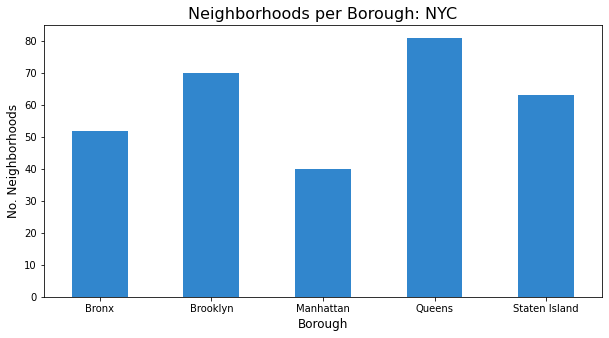

In [ ]:
clr = "#3186cd"
newyork_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 16)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. Neighborhoods',fontsize = 12)
plt.xticks(rotation = 'horizontal')
plt.show()

### Queens is the largest Borough with more than 80 Neighborhoods. Brooklyn, the second largest Borough account almost 70 Neighborhoods. Manhattan is the smallest with about 40 Neighborhoods.

## Locating using Foursquare

In [ ]:
CLIENT_ID = 'N5FHYAAPJ40G5EWXDZ5CPPENEPTY53H4XIEY4U5BNVCV5FI1'
CLIENT_SECRET = 'PR31X0GSWRT2IL0WIWXSYYSWGO1MEUJTXG4ZV0BFBVCOB5ZI'
VERSION = '20210215'
LIMIT = 30

## French restaurants located

In [ ]:
# French restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in newyork_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_rest=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(newyork_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_rest)))
    print(row)
    for rest_detail in french_rest.values.tolist():
        id, name , category=rest_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) French Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

In [ ]:
# Save the information to a .csv file
french_rest_ny.to_csv('french_rest_ny_tocsv1.csv', index=False) 

In [ ]:
french_rest_ny = pd.read_csv('french_rest_ny_tocsv1.csv')
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage


### France is always in the top 10 countries for the quality of their food. It's especially known for its finest cookery. Despite of their culinary skills, french cuisine seems to have trouble penetrating the thriving catering market in NYC. Only few Neighborhoods can boast the presence of french restaurants. The tables above and below show that there is only 55 french restaurants in the entire NYC.

In [ ]:
french_rest_ny.tail()

,Borough,Neighborhood,ID,Name
50,Manhattan,Sutton Place,4b70825df964a520e01e2de3,Bistro Vendome
51,Queens,Hunters Point,4a216706f964a520e27c1fe3,Tournesol
52,Manhattan,Turtle Bay,4a64fda8f964a52023c71fe3,Deux Amis
53,Queens,Sunnyside Gardens,57f57d5dcd1047e759ea8838,Côté Soleil
54,Queens,Sunnyside Gardens,4eceef679a52262b810ab3bd,Bliss 46 Bistro


In [ ]:
french_rest_ny.shape

(55, 4)

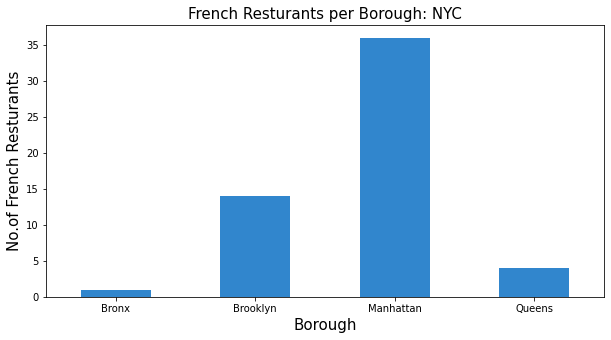

In [ ]:
french_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('French Resturants per Borough: NYC', fontsize = 15)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of French Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### The distribution of the 55 french restaurants in NYC are as follow: 36 in Manhattan, 14 in Brooklyn, 4 are located in Queens; one (Aperitif) in Bayside Neighborhood, one (Tournesol) in Hunters Point and two (Cote Soleil and Bliss 46 Bistro) in Sunnyside Gardens. One can see the strong presence of french restaurants in Manhattan as the desire to settle in the niche of the upper class. It's however hard to understan that the largest borough of NYC is only represented by 4 french restaurants.

In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Queens']

,Borough,Neighborhood,ID,Name
41,Queens,Bayside,54823da3498e2f6041ab87e2,apertif
51,Queens,Hunters Point,4a216706f964a520e27c1fe3,Tournesol
53,Queens,Sunnyside Gardens,57f57d5dcd1047e759ea8838,Côté Soleil
54,Queens,Sunnyside Gardens,4eceef679a52262b810ab3bd,Bliss 46 Bistro


In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Manhattan']

,Borough,Neighborhood,ID,Name
15,Manhattan,Central Harlem,4b80389ff964a520e95d30e3,Yatenga
16,Manhattan,Central Harlem,59cc6158c0af57432b9fd02b,Renaissance Harlem
17,Manhattan,East Harlem,553c1b00498e7eb81316bf1b,Mountain Bird
18,Manhattan,Upper East Side,3fd66200f964a5207fe91ee3,Café Boulud
19,Manhattan,Upper East Side,533b5715498ee1e90e846e1d,The Simone
20,Manhattan,Upper East Side,4408540af964a52055301fe3,Orsay
21,Manhattan,Lenox Hill,4f5977dee4b0e4b75e4295d6,Jean Claude II
22,Manhattan,Lenox Hill,51a7b2ebabd809839bcfa1da,Brasserie Cognac East
23,Manhattan,Lincoln Square,478cd1f3f964a520444d1fe3,Bar Boulud
24,Manhattan,Clinton,3fd66200f964a5208de91ee3,Chez Josephine


In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Manhattan'].shape

(36, 4)

In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Brooklyn']

,Borough,Neighborhood,ID,Name
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage
5,Brooklyn,Cobble Hill,4f7f8b86e4b088077df30175,Chez Moi
6,Brooklyn,Carroll Gardens,5df42352f93ca9000762ff64,Bar Bête
7,Brooklyn,Carroll Gardens,4e2ca88afa76bbf847e6886c,Jolie Bistro
8,Brooklyn,Fort Greene,5250553911d262bb0c732ee8,Cafe Paulette
9,Brooklyn,Fort Greene,422b9980f964a520d21f1fe3,Maison May
10,Brooklyn,Downtown,5ca3681932b61d0039533330,Pret A Manger


In [ ]:
french_rest_ny[french_rest_ny['Borough']=='Brooklyn'].shape

(14, 4)

### The distribution per neighborhood is also poor as shows the figure below. Only 4 Neighborhoods, all in Manhattan, have 3 french restaurants.

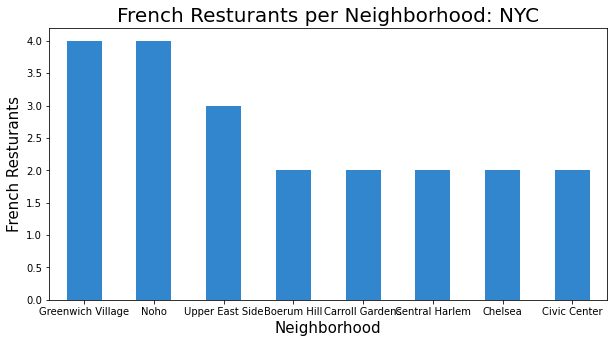

In [ ]:
Num_Neigh = 8 # top 5 for graphing 
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(Num_Neigh).plot.bar(figsize=(10,5), color=clr)
plt.title('French Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('French Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
stats_french_rest=pd.DataFrame(columns=column_names)
count=1
for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5 # 0 if does not exist in foursquare
    print('(',count,'/',len(french_rest_ny),')','processed')
    stats_french_rest = stats_french_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
stats_french_rest.head()

{'meta': {'code': 200, 'requestId': '60398df54a1f991192512d5f'}, 'response': {'venue': {'id': '4d7aa83ee540f04d66ba16dc', 'name': 'Bistro SK', 'contact': {'phone': '7188851670', 'formattedPhone': '(718) 885-1670'}, 'location': {'address': '273 City Island Ave', 'lat': 40.84638676701103, 'lng': -73.78626182722242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84638676701103, 'lng': -73.78626182722242}, {'label': 'entrance', 'lat': 40.846234, 'lng': -73.786269}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['273 City Island Ave', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bistro-sk/4d7aa83ee540f04d66ba16dc', 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats

KeyError: 'venue'

In [ ]:
stats_french_rest.to_csv('stats_french_rest_csv.csv', index=False)

In [ ]:
stats_french_rest = pd.read_csv('stats_french_rest_csv.csv')
stats_french_rest.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,23,8.6,3
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,159,7.7,73
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro,55,7.4,32
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage,99,7.9,25


### A deep analysis of rating shows the distribution of rating of french restaurants per Neighborhood. The tables above and below show that the best rating for restaurants are those located in Manhattan. Perhaps restaurants in Queens and in other Boroughs suffer from mismanagement.

In [ ]:
stats_french_rest.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
45,Manhattan,Noho,53b8c811498ee296db5cfaed,Dirty French,511,8.4,138
46,Manhattan,Noho,556b8dc2498eb674c015c301,Wildair,265,8.8,74
47,Manhattan,Civic Center,534c9d7b498e1bdd443a40e1,Racines,120,8.5,37
48,Manhattan,Civic Center,3fd66200f964a52083e61ee3,The Odeon,722,8.7,210
49,Manhattan,Midtown South,5b06b57962845c00242fb6be,Maison Kayser,34,8.0,5


In [ ]:
stats = stats_french_rest.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
stats.columns=['Borough','Average Rating']
stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,8.426471
1,Brooklyn,8.100000
0,Bronx,7.500000
3,Queens,0.000000


### The average rating for each Borough (table above) is very meaningful. Restaurants in Manhattan have the best rating. They are followed by those in Brooklyn, then by those in Bronx. Restaurants in Queens got a shameful rating. This finding should bring the management of said restaurants to a complete review of the processes in order to gain values in the sight of customers.

In [ ]:
address = 'Queens,NYC'

geolocator = Nominatim(user_agent='foursquare_agent')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Queens,NYC are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Queens,NYC are 40.7498243, -73.7976337.


## Map of Queens

In [ ]:
map_Queens = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
for lat, lng, nei in zip(newyork_data['Latitude'], newyork_data['Longitude'], newyork_data['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Queens)  
    
map_Queens